# Non-Max Supression: 
Non-Max Supression (NMS) is a technique used to select one bounding box for an object if multiple bounding boxes were detected with varying probability scores by object detection algorithms(example: Faster R-CNN,YOLO).

## Inputs:
   -  bboxes : Bounding Box Proposals.
   -  pscores: Probabilty scores for each proposal.
   -  threshold: Overlapping threshold above which proposals will be discarded.
   
## Output:
   - filtered_bboxes : Bounding Box proposals that are selected after applying non-max supression algorithm.
   
   
# Intersection Over Union(IOU):
Intersection over Union is an evaluation metric used to measure the accuracy of an predicted bounding box.

   <br>
   Input: 
   -  pbox : Predicted Bounding Box
   -  gbox : Ground truth Bounding Box
   <br>
   
Output:
   -  score : a float value in the range of [0,1] indicating how the two boxes are matching.

<img src="iou_equation.png">


# Python Implementation

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
FIG_SIZE = (30,20)

In [2]:
#NMS implementation in Python and Numpy
def nms_python(bboxes,psocres,threshold):
    '''
    NMS: first sort the bboxes by scores , 
        keep the bbox with highest score as reference,
        iterate through all other bboxes, 
        calculate Intersection Over Union (IOU) between reference bbox and other bbox
        if iou is greater than threshold,then discard the bbox and continue.
        
    Input:
        bboxes(numpy array of tuples) : Bounding Box Proposals in the format (x_min,y_min,x_max,y_max).
        pscores(numpy array of floats) : confidance scores for each bbox in bboxes.
        threshold(float): Overlapping threshold above which proposals will be discarded.
        
    Output:
        filtered_bboxes(numpy array) :selected bboxes for which IOU is less than threshold. 
    '''
    #Unstacking Bounding Box Coordinates
    bboxes = bboxes.astype('float')
    x_min = bboxes[:,0]
    y_min = bboxes[:,1]
    x_max = bboxes[:,2]
    y_max = bboxes[:,3]
    
    #Sorting the pscores in descending order and keeping respective indices.
    sorted_idx = psocres.argsort()[::-1]
    #Calculating areas of all bboxes.Adding 1 to the side values to avoid zero area bboxes.
    bbox_areas = (x_max-x_min+1)*(y_max-y_min+1)
    
    #list to keep filtered bboxes.
    filtered = []
    while len(sorted_idx) > 0:
        #Keeping highest pscore bbox as reference.
        rbbox_i = sorted_idx[0]
        #Appending the reference bbox index to filtered list.
        filtered.append(rbbox_i)
        
        #Calculating (xmin,ymin,xmax,ymax) coordinates of all bboxes w.r.t to reference bbox
        overlap_xmins = np.maximum(x_min[rbbox_i],x_min[sorted_idx[1:]])
        overlap_ymins = np.maximum(y_min[rbbox_i],y_min[sorted_idx[1:]])
        overlap_xmaxs = np.minimum(x_max[rbbox_i],x_max[sorted_idx[1:]])
        overlap_ymaxs = np.minimum(y_max[rbbox_i],y_max[sorted_idx[1:]])
        
        #Calculating overlap bbox widths,heights and there by areas.
        overlap_widths = np.maximum(0,(overlap_xmaxs-overlap_xmins+1))
        overlap_heights = np.maximum(0,(overlap_ymaxs-overlap_ymins+1))
        overlap_areas = overlap_widths*overlap_heights
        
        #Calculating IOUs for all bboxes except reference bbox
        ious = overlap_areas/(bbox_areas[rbbox_i]+bbox_areas[sorted_idx[1:]]-overlap_areas)
        
        #select indices for which IOU is greather than threshold
        delete_idx = np.where(ious > threshold)[0]+1
        delete_idx = np.concatenate(([0],delete_idx))
        
        #delete the above indices
        sorted_idx = np.delete(sorted_idx,delete_idx)
        
    
    #Return filtered bboxes
    return bboxes[filtered].astype('int')

In [3]:
#Reading image and copying for furthur use.
sampleimage = cv2.imread("sample_image.jpg")
sampleimage = cv2.cvtColor(sampleimage,cv2.COLOR_BGR2RGB)
sampleimageallbb = sampleimage.copy()
sampleimagenmsbb = sampleimage.copy()

In [4]:
#Sample BBoxes and corresponding scores.
bboxes = np.array([(165,127,296,455),(148,142,257,459),(142,137,270,465),(129,122,302,471),
                   (327,262,604,465),(349,253,618,456),(369,248,601,470)])
pscores = np.array([0.8,0.95,0.81,0.85,0.94,0.83,0.82])

# Testing Python Implementation

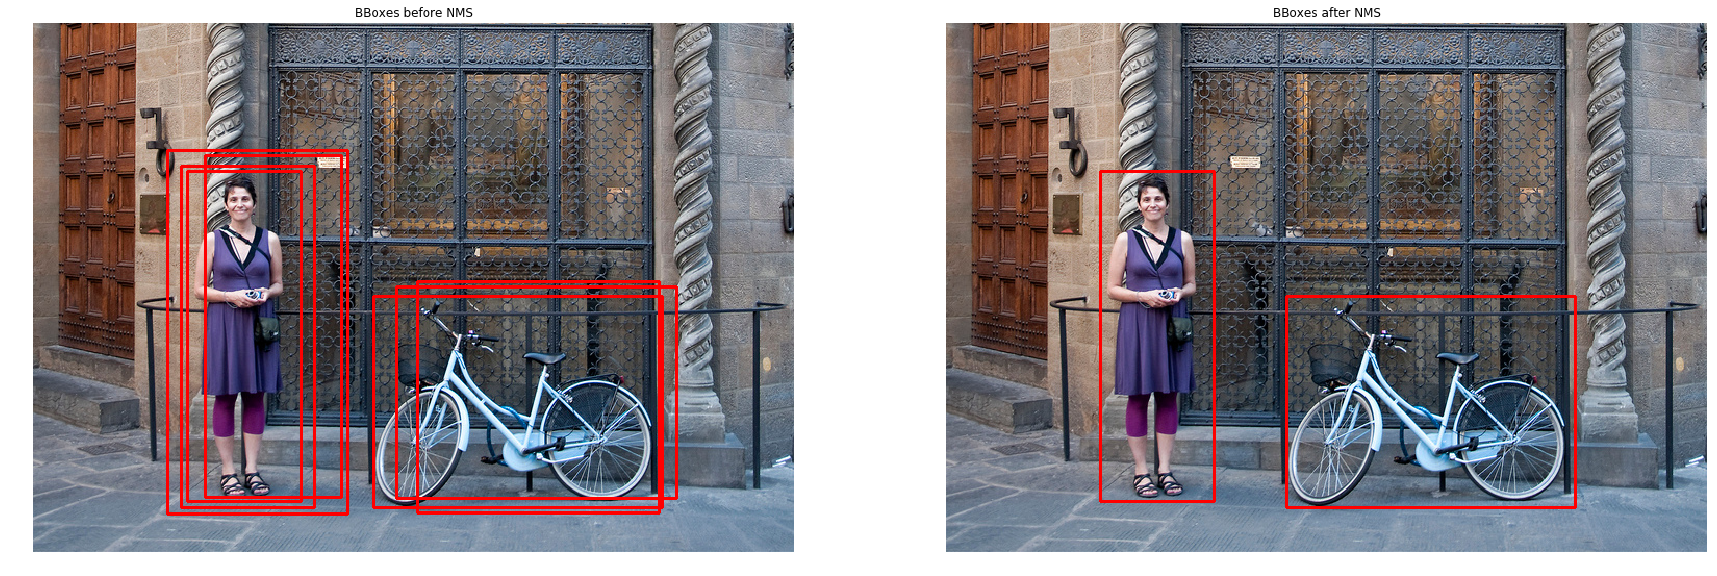

In [5]:
#Drawing all rectangular bboxes on original image
for bbox in bboxes:
    top_left = bbox[0],bbox[1]
    bottom_right = bbox[2],bbox[3]
    cv2.rectangle(sampleimageallbb,top_left, bottom_right,(255, 0, 0), 2)
    
#Getting nms filtered bboxes
bboxes_after_nms = nms_python(bboxes,pscores,0.3)

#Drawing nms filtered rectangular bboxes on original image
for bbox in bboxes_after_nms:
    top_left = bbox[0],bbox[1]
    bottom_right = bbox[2],bbox[3]
    cv2.rectangle(sampleimagenmsbb,top_left, bottom_right,(255, 0, 0), 2)
    
image_list = [sampleimageallbb,sampleimagenmsbb]
titles = ["BBoxes before NMS","BBoxes after NMS"]
    
fig, axes = plt.subplots(1, 2,figsize=FIG_SIZE)
for axis,(image,title) in zip(axes,zip(image_list,titles)):
    axis.imshow(image)
    axis.axis('off')
    axis.set_title(title)
plt.show()

# Tensorflow Implementation

In [6]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [7]:
#NMS implementation in tensorflow
def nms_tf(bboxes,psocres,threshold):
    '''
    NMS: NMS using in-built tf.image.non_max_suppression(bboxes,scores,top_n_proposal_after_nms,iou_threshould)
        
    Input:
        bboxes(tensor of bounding proposals) : Bounding Box Proposals in the format (x_min,y_min,x_max,y_max)
        threshold(float): Overlapping threshold above which proposals will be discarded.
        
    Output:
        filtered_bboxes(numpy array) :selected bboxes for which IOU is less than threshold.
    '''
    
    #First we need to convert bbox format from (x_min,y_min,x_max,y_max) to (y_min, x_min, y_max, x_max) ..
    #because tf.image.non_max_suppression method expects in that form.
    #For this we can use tf.unstack and tf.stack
    bboxes = tf.cast(bboxes,dtype=tf.float32)
    x_min,y_min,x_max,y_max = tf.unstack(bboxes,axis=1)
    bboxes = tf.stack([y_min,x_min,y_max,x_max],axis=1)
    bbox_indices = tf.image.non_max_suppression(bboxes,psocres, 100, iou_threshold=threshold)
    filtered_bboxes = tf.gather(bboxes,bbox_indices)
    scores = tf.gather(psocres,bbox_indices)
    y_min,x_min,y_max,x_max = tf.unstack(filtered_bboxes,axis=1)
    filtered_bboxes = tf.stack([x_min,y_min,x_max,y_max],axis=1)
    
    
    return filtered_bboxes

# Testing Tensorflow Implementation

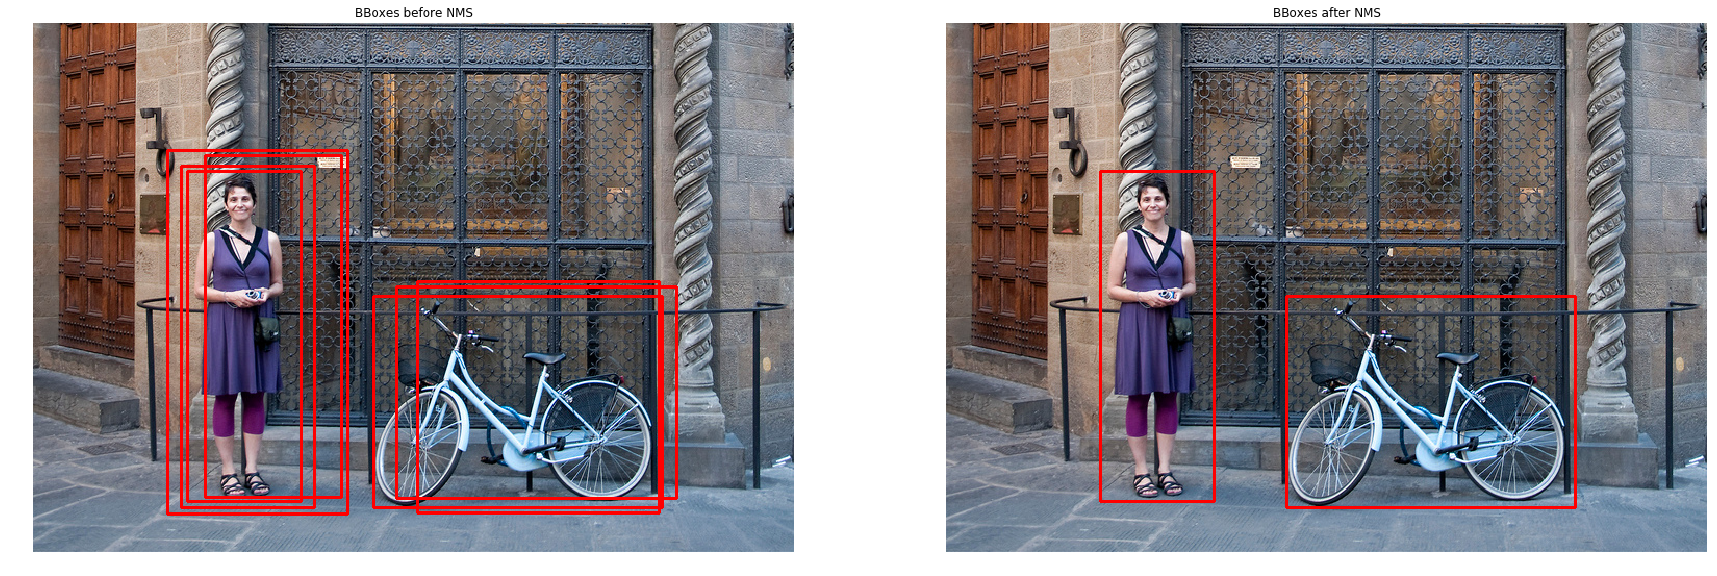

In [8]:
sampleimagetfnmsbb = sampleimage.copy()

#Getting nms filtered bboxes
bboxes_tensor = tf.convert_to_tensor(bboxes,dtype=tf.float32)
pscores_tensor = tf.convert_to_tensor(pscores,dtype=tf.float32)
bboxes_after_nms = nms_tf(bboxes_tensor,pscores_tensor,0.3)
bboxes_after_nms = bboxes_after_nms.numpy()

#Drawing nms filtered rectangular bboxes on original image
for bbox in bboxes_after_nms:
    top_left = bbox[0],bbox[1]
    bottom_right = bbox[2],bbox[3]
    cv2.rectangle(sampleimagetfnmsbb,top_left, bottom_right,(255, 0, 0), 2)
    
image_list = [sampleimageallbb,sampleimagetfnmsbb]
titles = ["BBoxes before NMS","BBoxes after NMS"]
    
fig, axes = plt.subplots(1, 2,figsize=FIG_SIZE)
for axis,(image,title) in zip(axes,zip(image_list,titles)):
    axis.imshow(image)
    axis.axis('off')
    axis.set_title(title)
plt.show()

## References:
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/